## LIBRERIAS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from stastmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
import warnings
# import ace_tools as tools

In [22]:
path_prueba = 'salidas/01_igual_ultimo_periodo.xlsm'
df= pd.read_excel(path_prueba,decimal=',')  

In [23]:
print(df.sort_values('diferencias', ascending=False))

     product_id       ultimo         serie   diferencias
197       20241     12.81580  21921.000000  21908.184200
377       20488      8.62499  10795.000000  10786.375010
550       20754      8.55531  10301.000000  10292.444690
31        20032    527.79811    796.693521    268.895411
1         20002   1087.30855   1313.209715    225.901165
..          ...          ...           ...           ...
527       20713   1468.00000      2.932062  -1465.067938
436       20579   3101.00000      5.554633  -3095.445367
293       20357  18325.00000     14.985737 -18310.014263
241       20297  35089.00000     26.199932 -35062.800068
121       20140  58149.00000     58.887986 -58090.112014

[780 rows x 4 columns]


In [17]:
x

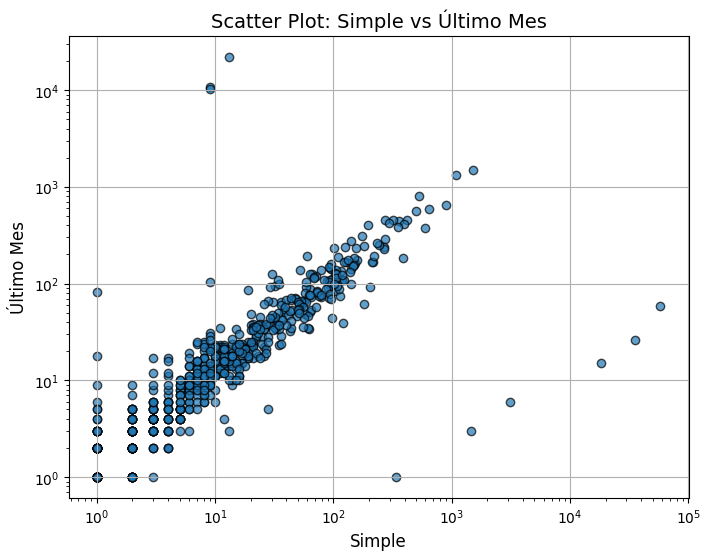

In [14]:


# Crear el scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df['simple'], df['ultimo mes'], alpha=0.7, edgecolors='k')

# Configurar etiquetas y título
plt.title('Scatter Plot: Simple vs Último Mes', fontsize=14)
plt.xlabel('Simple', fontsize=12)
plt.ylabel('Último Mes', fontsize=12)
plt.xscale('log')
plt.yscale('log')

plt.grid(True)
# Mostrar el gráfico
plt.show()

### CARGAR DATOS Y ANALISIS GENERAL

In [3]:
sell_in = pd.read_csv('sell-in.txt.gz', compression='gzip', sep='\t')
prod_predecir = pd.read_csv('tb_prod_predecir.txt', sep='\t')  

sell_in_Final = pd.merge(
    sell_in, 
    prod_predecir, 
    on='product_id',  # Especifica la columna común para el join
    how='inner'       # Solo incluir registros que coinciden en ambas tablas
)

In [51]:
print("Información de columnas y tipos:")
print(sell_in.info())
print(sell_in.head(10))

Información de columnas y tipos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945818 entries, 0 to 2945817
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   periodo                int64  
 1   customer_id            int64  
 2   product_id             int64  
 3   plan_precios_cuidados  int64  
 4   cust_request_qty       int64  
 5   cust_request_tn        float64
 6   tn                     float64
dtypes: float64(2), int64(5)
memory usage: 157.3 MB
None
   periodo  customer_id  product_id  plan_precios_cuidados  cust_request_qty  \
0   201701        10234       20524                      0                 2   
1   201701        10032       20524                      0                 1   
2   201701        10217       20524                      0                 1   
3   201701        10125       20524                      0                 1   
4   201701        10012       20524                      0                

In [ ]:
# Filtrar el último mes del dataset
sell_in_last_month = sell_in[sell_in['periodo'] >= 201912]

# Mostrar las primeras filas del resultado
print(sell_in_last_month.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 57922 entries, 2887896 to 2945817
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   periodo                57922 non-null  int64  
 1   customer_id            57922 non-null  int64  
 2   product_id             57922 non-null  int64  
 3   plan_precios_cuidados  57922 non-null  int64  
 4   cust_request_qty       57922 non-null  int64  
 5   cust_request_tn        57922 non-null  float64
 6   tn                     57922 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 3.5 MB
None


### Primera Salida tomando el ultimo mes con valores y lo uso como pronostico

In [61]:
sell_in_Final['periodo'].unique()

<DatetimeArray>
['2017-01-01 00:00:00', '2017-02-01 00:00:00', '2017-03-01 00:00:00',
 '2017-04-01 00:00:00', '2017-05-01 00:00:00', '2017-06-01 00:00:00',
 '2017-07-01 00:00:00', '2017-08-01 00:00:00', '2017-09-01 00:00:00',
 '2017-10-01 00:00:00', '2017-11-01 00:00:00', '2017-12-01 00:00:00',
 '2018-01-01 00:00:00', '2018-02-01 00:00:00', '2018-03-01 00:00:00',
 '2018-04-01 00:00:00', '2018-05-01 00:00:00', '2018-06-01 00:00:00',
 '2018-07-01 00:00:00', '2018-08-01 00:00:00', '2018-09-01 00:00:00',
 '2018-10-01 00:00:00', '2018-11-01 00:00:00', '2018-12-01 00:00:00',
 '2019-01-01 00:00:00', '2019-02-01 00:00:00', '2019-03-01 00:00:00',
 '2019-04-01 00:00:00', '2019-05-01 00:00:00', '2019-06-01 00:00:00',
 '2019-07-01 00:00:00', '2019-08-01 00:00:00', '2019-09-01 00:00:00',
 '2019-10-01 00:00:00', '2019-11-01 00:00:00', '2019-12-01 00:00:00']
Length: 36, dtype: datetime64[ns]

In [46]:
sell_in_filtered = pd.merge(
    sell_in_last_month, 
    prod_predecir, 
    on='product_id',  # Especifica la columna común para el join
    how='inner'       # Solo incluir registros que coinciden en ambas tablas
)

# Agrupar por periodo y product_id, y calcular la suma de tn
sell_in_grouped = sell_in_filtered.groupby(['periodo', 'product_id'])['tn'].sum().reset_index()

# Reemplazar los valores de la columna periodo
sell_in_grouped['periodo'] = sell_in_grouped['periodo'].replace(201912, 202002)

sell_in_grouped = sell_in_grouped.drop(columns=['periodo'])
# Mostrar las primeras filas del DataFrame actualizado
print(sell_in_grouped.head())

# Mostrar las primeras filas del nuevo DataFrame
print(sell_in_grouped.head())
print(len(sell_in_grouped))

# exportar sell_in_grouped a un archivo CSV
sell_in_grouped.to_csv('01_igual_ultimo_periodo.csv', index=False)


   product_id          tn
0       20001  1504.68856
1       20002  1087.30855
2       20003   892.50129
3       20004   637.90002
4       20005   593.24443
   product_id          tn
0       20001  1504.68856
1       20002  1087.30855
2       20003   892.50129
3       20004   637.90002
4       20005   593.24443
780


## Salida Promedio N Meses

In [63]:
def promedio_ultimos_N_meses(df, columna_periodo='periodo', columna_producto='product_id', columna_valor='tn', n_meses=12): 
    # Asegurarse de que la columna periodo esté en formato datetime
    df[columna_periodo] = pd.to_datetime(df[columna_periodo], format='%Y%m', errors='coerce')

    # Filtrar los últimos 12 meses
    fecha_maxima = df[columna_periodo].max()
    fecha_minima = fecha_maxima - pd.DateOffset(months=n_meses)
    print(fecha_maxima)
    print(fecha_minima)
    df_filtrado = df[(df[columna_periodo] >= fecha_minima) & (df[columna_periodo] <= fecha_maxima)]

    # Agrupar por producto y calcular el promedio
    promedio_por_producto = df_filtrado.groupby(columna_producto)[columna_valor].mean().reset_index()

    # Renombrar la columna del promedio
    promedio_por_producto.rename(columns={columna_valor: 'promedio_12_meses'}, inplace=True)

    return promedio_por_producto




## usando solo promedios

In [ ]:
# Usar la función con el DataFrame sell_in_last_month
n_meses=3
promedio_N_meses = promedio_ultimos_N_meses(sell_in_Final, 
                                            columna_periodo='periodo', 
                                            columna_producto='product_id', 
                                            columna_valor='tn',n_meses=n_meses)

# Mostrar las primeras filas del resultado
print(promedio_N_meses.head())
nombre_archivo = 'Promedio_' + str(n_meses) + '.csv'
promedio_N_meses.to_csv(nombre_archivo, index=False)

### Usando promedios y factor

In [71]:
# Usar la función con el DataFrame sell_in_last_month
n_meses=12
factor = 1.04

promedio_N_meses = promedio_ultimos_N_meses(sell_in_Final, 
                                            columna_periodo='periodo', 
                                            columna_producto='product_id', 
                                            columna_valor='tn',n_meses=n_meses)

promedio_N_meses['promedio_12_meses'] = promedio_N_meses['promedio_12_meses'] * factor

# Mostrar las primeras filas del resultado
print(promedio_N_meses.head())
nombre_archivo = 'Promedio_Y_factor_2' + str(n_meses) + '.csv'
promedio_N_meses.to_csv(nombre_archivo, index=False)


2019-12-01 00:00:00
2018-12-01 00:00:00
   product_id  promedio_12_meses
0       20001           9.245058
1       20002           7.697986
2       20003           4.743566
3       20004           3.477591
4       20005           4.457380


## Usando Arima

In [ ]:
def ajustar_arima_por_producto(df, columna_periodo='periodo', columna_producto='product_id', columna_valor='tn', orden=(1, 1, 1)):
   
    resultados_arima = {}

    # Asegurarse de que la columna periodo esté en formato datetime
    df[columna_periodo] = pd.to_datetime(df[columna_periodo], format='%Y%m', errors='coerce')

    # Iterar sobre cada product_id único
    for producto in df[columna_producto].unique():
        # Filtrar los datos para el producto actual
        datos_producto = df[df[columna_producto] == producto].sort_values(by=columna_periodo)

        # Verificar que haya suficientes datos para ajustar el modelo
        if len(datos_producto) < 10:  # Ajusta este valor según tus necesidades
            print(f"Producto {producto} tiene menos de 10 registros. No se ajustará ARIMA.")
            continue

        # Ajustar el modelo ARIMA
        try:
            modelo = ARIMA(datos_producto[columna_valor], order=orden)
            resultado = modelo.fit()

            # Guardar el resultado en el diccionario
            resultados_arima[producto] = resultado
        except Exception as e:
            print(f"Error al ajustar ARIMA para el producto {producto}: {e}")

    return resultados_arima


# Usar la función con el DataFrame sell_in_Final
orden_arima = (2, 1, 2)  # Ajusta el orden según tus necesidades
resultados_arima = ajustar_arima_por_producto(sell_in_Final, columna_periodo='periodo', columna_producto='product_id', columna_valor='tn', orden=orden_arima)

# Mostrar los resultados para un producto específico
for producto, resultado in resultados_arima.items():
    print(f"Producto: {producto}")
    print(resultado.summary())
    print("\n")

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported ind

In [1]:
resultado

NameError: name 'resultado' is not defined

In [5]:
sell_in_Final

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,periodo_dt
0,201701,10234,20524,0,2,0.05300,0.05300,2017-01-01
1,201701,10032,20524,0,1,0.13628,0.13628,2017-01-01
2,201701,10217,20524,0,1,0.03028,0.03028,2017-01-01
3,201701,10125,20524,0,1,0.02271,0.02271,2017-01-01
4,201701,10012,20524,0,11,1.54452,1.54452,2017-01-01
...,...,...,...,...,...,...,...,...
2293476,201912,10105,20853,0,1,0.02230,0.02230,2019-12-01
2293477,201912,10092,20853,0,1,0.00669,0.00669,2019-12-01
2293478,201912,10006,20853,0,7,0.02898,0.02898,2019-12-01
2293479,201912,10018,20853,0,4,0.01561,0.01561,2019-12-01


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


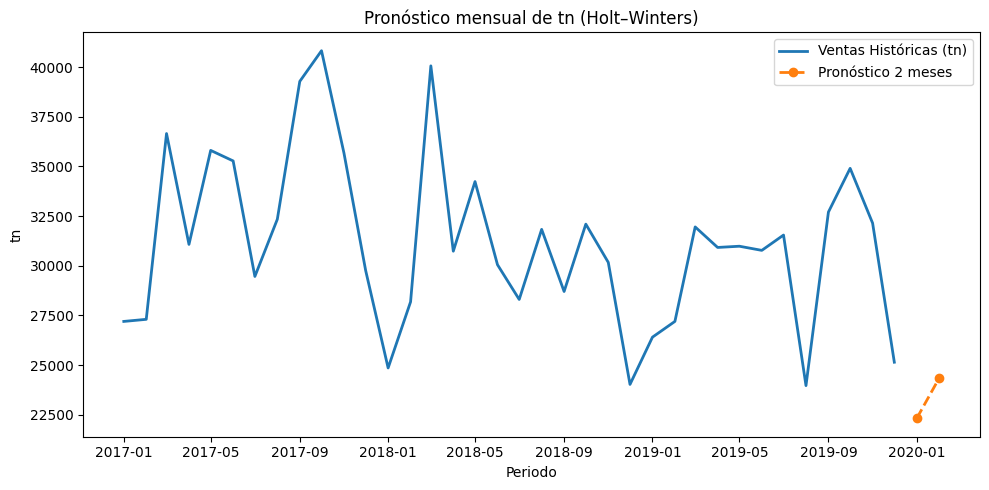

Pronóstico para los próximos 2 meses:
  periodo_dt   forecast_tn
0 2020-01-01  22319.984635
1 2020-02-01  24351.495119


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. Agregar tn por mes (suponiendo que ya tienes 'periodo_dt' como datetime)
monthly_sales = sell_in_Final.groupby('periodo_dt')['tn'].sum().asfreq('MS')

# 2. Interpolar valores faltantes si los hubiese
monthly_sales = monthly_sales.interpolate(method='linear')

# 3. Ajustar modelo Holt–Winters (tendencia+estacionalidad aditiva, periodo 12 meses)
model_hw = ExponentialSmoothing(
    monthly_sales,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

# 4. Pronosticar 2 meses hacia adelante
forecast_2 = model_hw.forecast(2)

# 5. Graficar serie histórica y pronóstico
plt.figure(figsize=(10, 5))
plt.plot(monthly_sales, label='Ventas Históricas (tn)', linewidth=2)
plt.plot(forecast_2, label='Pronóstico 2 meses', marker='o', linestyle='--', linewidth=2)
plt.title('Pronóstico mensual de tn (Holt–Winters)')
plt.xlabel('Periodo')
plt.ylabel('tn')
plt.legend()
plt.tight_layout()
plt.show()

# 6. Preparar DataFrame con los valores pronosticados
forecast_df = forecast_2.reset_index()
forecast_df.columns = ['periodo_dt', 'forecast_tn']
print("Pronóstico para los próximos 2 meses:")
print(forecast_df)


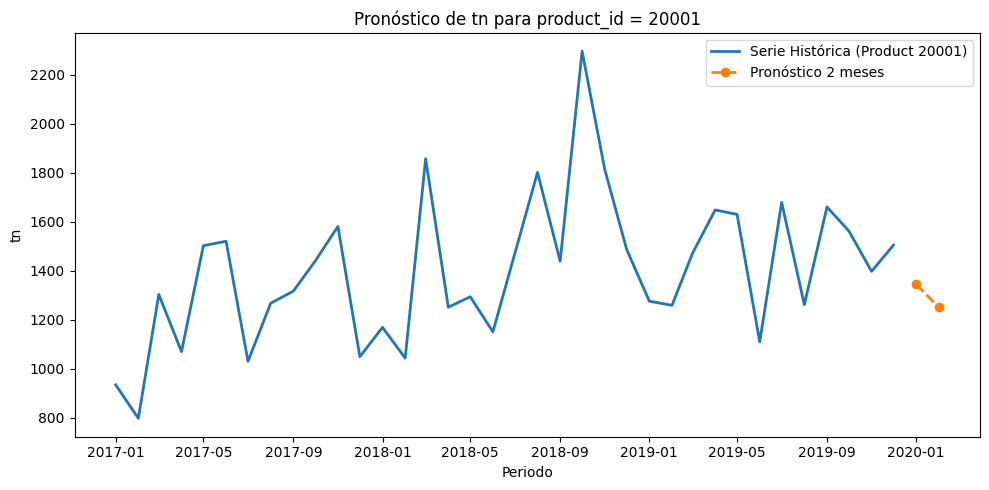

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# 1. Crear un DataFrame para guardar todos los pronósticos
forecast_list = []

# 2. Iterar por cada product_id
for pid, group in sell_in_Final.groupby('product_id'):
    # 2.1. Agregar tn por mes para este producto
    ts = group.groupby('periodo_dt')['tn'].sum().asfreq('MS')
    # 2.2. Interpolar faltantes si los hay
    ts = ts.interpolate(method='linear')
    
    # 2.3. Solo ajustar el modelo si hay suficientes datos (por ejemplo, al menos 24 meses)
    if len(ts.dropna()) < 24:
        continue
    
    try:
        # 2.4. Ajustar Holt–Winters (tendencia+estacionalidad aditiva, período = 12 meses)
        model_hw = ExponentialSmoothing(
            ts,
            trend='add',
            seasonal='add',
            seasonal_periods=12
        ).fit()
        
        # 2.5. Pronosticar 2 meses hacia adelante
        fc = model_hw.forecast(2)
        
        # 2.6. Crear un pequeño DataFrame con el pronóstico para este product_id
        df_fc = fc.reset_index()
        df_fc.columns = ['periodo_dt', 'forecast_tn']
        df_fc['product_id'] = pid
        
        # 2.7. Agregar a la lista de pronósticos
        forecast_list.append(df_fc)
        
    except Exception as e:
        # Si el ajuste falla (p.ej. datos insuficientes), pasamos al siguiente producto
        continue

# 3. Concatenar todos los DataFrames de pronóstico en uno solo
forecast_df = pd.concat(forecast_list, ignore_index=True)

# 4. Mostrar los primeros pronósticos generados
forecast_df.head()

# 5. (Opcional) Graficar un ejemplo para un product_id específico:
#     Selecciona el primer product_id de la lista para visualizar
if not forecast_list:
    print("No se generaron pronósticos: quizá no hay ningún 'product_id' con suficientes datos.")
else:
    example_pid = forecast_list[0]['product_id'].iloc[0]
    ts_example = (
        sell_in_Final[sell_in_Final['product_id'] == example_pid]
        .groupby('periodo_dt')['tn']
        .sum()
        .asfreq('MS')
        .interpolate(method='linear')
    )
    fc_example = forecast_df[forecast_df['product_id'] == example_pid].set_index('periodo_dt')['forecast_tn']
    
    plt.figure(figsize=(10, 5))
    plt.plot(ts_example, label=f'Serie Histórica (Product {example_pid})', linewidth=2)
    plt.plot(fc_example, label='Pronóstico 2 meses', 
             marker='o', linestyle='--', linewidth=2)
    plt.title(f'Pronóstico de tn para product_id = {example_pid}')
    plt.xlabel('Periodo')
    plt.ylabel('tn')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [19]:
forecast_df

,periodo_dt,forecast_tn,product_id
0,2020-01-01,1344.878590,20001
1,2020-02-01,1251.351350,20001
2,2020-01-01,1368.258434,20002
3,2020-02-01,1161.086459,20002
4,2020-01-01,732.369603,20003
...,...,...,...
1131,2020-02-01,-0.081835,21218
1132,2020-01-01,0.156286,21222
1133,2020-02-01,0.012777,21222
1134,2020-01-01,0.078791,21224


In [20]:
forecast_df_ultimomes = forecast_df[forecast_df['periodo_dt'] >= '2020-02-01']


In [ ]:

forecast_df_ultimomes.to_csv("arima_con_.csv", index=False)

In [21]:
forecast_df_ultimomes

,periodo_dt,forecast_tn,product_id
1,2020-02-01,1251.351350,20001
3,2020-02-01,1161.086459,20002
5,2020-02-01,529.303956,20003
7,2020-02-01,362.811640,20004
9,2020-02-01,433.193391,20005
...,...,...,...
1127,2020-02-01,0.047271,21207
1129,2020-02-01,-0.003728,21212
1131,2020-02-01,-0.081835,21218
1133,2020-02-01,0.012777,21222
